## Background
### Introduction
Our goal with this project is to use machine learning to make scientific discoveries in archived data. We're going to be focusing on galaxy images from the infamous Hubble Space Telescope. While all these images are beautiful, we're looking for anything unusual or weird that might warrant further investigation. In other words, we want to find anything that doesn't look like a "boring" spiral or elliptical galaxy (you can see below some examples of "boring" galaxies).

But why would we want to do this? Can't you just look at the data and find the interesting things? You can, as long as the dataset is small enough. The dataset we've put together for you has over 17000 images, which would take you hours or even days to look through. And this is a tiny subset of all the images that are in the Hubble archive, which number in the millions. As more powerful telescopes are being built, the data rates are just increasing and we need to turn to automated methods to help us make new discoveries.

### Resources
**Hubble and Galaxy Zoo** <br>
https://hubblesite.org/home <br>
https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/ <br>
**General machine learning** <br>
https://www.youtube.com/watch?v=gLD8I3zcjB0 <br>
https://www.youtube.com/watch?v=ubhLmFQPgjc&t=1152s <br>
https://www.youtube.com/watch?v=g7caAxKBptc (much more advanced talk) <br>
**Convolutional neural networks and feature extraction** <br>
https://www.datacamp.com/tutorial/introduction-to-convolutional-neural-networks-cnns <br>
https://www.youtube.com/watch?v=RZvPgSiOYas (not fantastic but best I could find) <br>
**Local outlier factor** <br>
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html <br>
https://medium.com/@pramodch/understanding-lof-local-outlier-factor-for-implementation-1f6d4ff13ab9 <br>


### Import packages

In [209]:
import os
from pathlib import Path                                           # Used to handle filesystem paths
import pandas as pd                                                # Used to read in and work with the data as a "DataFrame"
import numpy as np                                                 # Our favourite numerical library
import matplotlib.pyplot as plt                                    # Our favourite plotting library
from sklearn.neighbors import LocalOutlierFactor                   # The suggested anomaly detection algorithm
from PIL import Image                                              # This library will allow us to easily display png files in the notebook
from matplotlib.colors import LogNorm
from sklearn.decomposition import PCA

### Read the relevant files

In [210]:
## The paths to the data and images directories in the team workspace
print('current working dir', os.getcwd())

## load data
data_directory = '/media/user/data/' 
images_directory = Path('/media/team_workspaces/astronomaly-project/images')

## The zoobot features after running PCA
features_reduced = pd.read_csv(data_directory + 'all-pca-components-refined.csv', index_col= 0)

## Coordinates for the sources
source_coords = pd.read_csv(data_directory + 'source-coordinates.csv', index_col= 1)

current working dir /media/user/Galaxy-Classification/notebooks


### Open the data

#### Each row of the DataFrame has a unique index which helps us keep track of exactly which set of numbers belongs to which source. 

In [211]:
features_reduced.head()

SourceID                                           file_loc  \
0     AHZ2000ap3  /media/team_workspaces/astronomaly-project/ima...   
1  4000712889196  /media/team_workspaces/astronomaly-project/ima...   
2  4000710658615  /media/team_workspaces/astronomaly-project/ima...   
3     AHZ2000ow7  /media/team_workspaces/astronomaly-project/ima...   
4     4111276917  /media/team_workspaces/astronomaly-project/ima...   

   feat_0_pca  feat_1_pca  feat_2_pca  feat_3_pca  feat_4_pca  feat_5_pca  \
0    0.644151   -0.607720   -0.652212    0.161491    0.329425   -0.111614   
1    1.793052   -0.652613   -0.547502   -0.185649    0.189948    0.280023   
2    1.944819   -0.582089   -0.348063   -0.240915    0.122469    0.270349   
3   -0.111912   -0.038260    0.540898    0.007854    0.466451    0.022677   
4   -1.876487    0.702289    0.362675   -0.520290    0.039717   -0.165041   

   feat_6_pca  feat_7_pca  ...  feat_30_pca  feat_31_pca  feat_32_pca  \
0   -0.078075    0.243963  ...    -0.047008     0.034110     0.045288   
1   -0.285091    0.526109  ...    -0.011317     0.019125    -0.010794   
2   -0.146614    0.333893  ...     0.003306     0.047460     0.016832   
3   -0.420133    0.039169  ...     0.072039    -0.012041    -0.008450   
4   -0.341243    0.122296  ...    -0.077778     0.000792    -0.052679   

   feat_33_pca  feat_34_pca  feat_35_pca  feat_36_pca  feat_37_pca  \
0    -0.014910    -0.027302    -0.006636     0.066010     0.091932   
1    -0.032408     0.003039    -0.010592     0.056721    -0.019649   
2    -0.037377     0.016838     0.003930     0.026537    -0.018909   
3    -0.006786     0.015151     0.015686    -0.020232    -0.018433   
4     0.002063    -0.001525    -0.030409    -0.050910    -0.043423   

   feat_38_pca  feat_39_pca  
0     0.000969     0.081786  
1    -0.013452     0.017829  
2    -0.034380     0.011928  
3     0.018422    -0.000777  
4     0.009688     0.039821  

[5 rows x 42 columns]

## Preprocessing

In [212]:
## shape of the data
features_reduced.shape

(17390, 42)

In [213]:
## info about the data
features_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17390 entries, 0 to 17600
Data columns (total 42 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SourceID     17390 non-null  object 
 1   file_loc     17390 non-null  object 
 2   feat_0_pca   17390 non-null  float64
 3   feat_1_pca   17390 non-null  float64
 4   feat_2_pca   17390 non-null  float64
 5   feat_3_pca   17390 non-null  float64
 6   feat_4_pca   17390 non-null  float64
 7   feat_5_pca   17390 non-null  float64
 8   feat_6_pca   17390 non-null  float64
 9   feat_7_pca   17390 non-null  float64
 10  feat_8_pca   17390 non-null  float64
 11  feat_9_pca   17390 non-null  float64
 12  feat_10_pca  17390 non-null  float64
 13  feat_11_pca  17390 non-null  float64
 14  feat_12_pca  17390 non-null  float64
 15  feat_13_pca  17390 non-null  float64
 16  feat_14_pca  17390 non-null  float64
 17  feat_15_pca  17390 non-null  float64
 18  feat_16_pca  17390 non-null  float64
 19  feat

In [214]:
print(features_reduced.dtypes)

SourceID        object
file_loc        object
feat_0_pca     float64
feat_1_pca     float64
feat_2_pca     float64
feat_3_pca     float64
feat_4_pca     float64
feat_5_pca     float64
feat_6_pca     float64
feat_7_pca     float64
feat_8_pca     float64
feat_9_pca     float64
feat_10_pca    float64
feat_11_pca    float64
feat_12_pca    float64
feat_13_pca    float64
feat_14_pca    float64
feat_15_pca    float64
feat_16_pca    float64
feat_17_pca    float64
feat_18_pca    float64
feat_19_pca    float64
feat_20_pca    float64
feat_21_pca    float64
feat_22_pca    float64
feat_23_pca    float64
feat_24_pca    float64
feat_25_pca    float64
feat_26_pca    float64
feat_27_pca    float64
feat_28_pca    float64
feat_29_pca    float64
feat_30_pca    float64
feat_31_pca    float64
feat_32_pca    float64
feat_33_pca    float64
feat_34_pca    float64
feat_35_pca    float64
feat_36_pca    float64
feat_37_pca    float64
feat_38_pca    float64
feat_39_pca    float64
dtype: object


###

In [215]:
## check missing values
features_reduced.isna()

SourceID  file_loc  feat_0_pca  feat_1_pca  feat_2_pca  feat_3_pca  \
0         False     False       False       False       False       False   
1         False     False       False       False       False       False   
2         False     False       False       False       False       False   
3         False     False       False       False       False       False   
4         False     False       False       False       False       False   
...         ...       ...         ...         ...         ...         ...   
17596     False     False       False       False       False       False   
17597     False     False       False       False       False       False   
17598     False     False       False       False       False       False   
17599     False     False       False       False       False       False   
17600     False     False       False       False       False       False   

       feat_4_pca  feat_5_pca  feat_6_pca  feat_7_pca  ...  feat_30_pca  \
0           False       False       False       False  ...        False   
1           False       False       False       False  ...        False   
2           False       False       False       False  ...        False   
3           False       False       False       False  ...        False   
4           False       False       False       False  ...        False   
...           ...         ...         ...         ...  ...          ...   
17596       False       False       False       False  ...        False   
17597       False       False       False       False  ...        False   
17598       False       False       False       False  ...        False   
17599       False       False       False       False  ...        False   
17600       False       False       False       False  ...        False   

       feat_31_pca  feat_32_pca  feat_33_pca  feat_34_pca  feat_35_pca  \
0            False        False        False        False        False   
1            False        False        False        False        False   
2            False        False        False        False        False   
3            False        False        False        False        False   
4            False        False        False        False        False   
...            ...          ...          ...          ...          ...   
17596        False        False        False        False        False   
17597        False        False        False        False        False   
17598        False        False        False        False        False   
17599        False        False        False        False        False   
17600        False        False        False        False        False   

       feat_36_pca  feat_37_pca  feat_38_pca  feat_39_pca  
0            False        False        False        False  
1            False        False        False        False  
2            False        False        False        False  
3            False        False        False        False  
4            False        False        False        False  
...            ...          ...          ...          ...  
17596        False        False        False        False  
17597        False        False        False        False  
17598        False        False        False        False  
17599        False        False        False        False  
17600        False        False        False        False  

[17390 rows x 42 columns]

In [216]:
features_reduced.isna().sum().sum()

0

### No missing values on dataset

### We can check and study the second data frame, `source_coords` - position data frame

In [217]:
## 
source_coords.head()

Unnamed: 0                  RA                  Dec  \
SourceID                                                             
AHZ2000ap3              0         150.3053182            1.8976633   
4000712889196           1          11.4864402           41.9962016   
4000710658615           2          11.4642217           42.1513209   
AHZ2000ow7              3  150.53574609999998            2.1374021   
4111276917              4          344.677271  -34.824124299999994   

                                                        file_loc  
SourceID                                                          
AHZ2000ap3     /media/team_workspaces/astronomaly-project/ima...  
4000712889196  /media/team_workspaces/astronomaly-project/ima...  
4000710658615  /media/team_workspaces/astronomaly-project/ima...  
AHZ2000ow7     /media/team_workspaces/astronomaly-project/ima...  
4111276917     /media/team_workspaces/astronomaly-project/ima...

In [218]:
## shape
source_coords.shape

(17601, 4)

In [219]:
source_coords.dtypes

Unnamed: 0     int64
RA            object
Dec           object
file_loc      object
dtype: object

### we can drop unnamed column/axis1 `Unnamed: 0`

In [220]:
source_coords = source_coords.drop('Unnamed: 0', axis=1)

In [221]:
source_coords.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17601 entries, AHZ2000ap3 to COS_2333
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   RA        15782 non-null  object
 1   Dec       15782 non-null  object
 2   file_loc  17601 non-null  object
dtypes: object(3)
memory usage: 550.0+ KB


####

### we can see that features are mixed up with information about the source like its name and where the file is stored. For algorithm simplicity we need to drop them. we can do so by spliting the data set with its copy

In [222]:
## a copy of the two dataframes
features = features_reduced.copy()
positions = source_coords.copy()

##

In [223]:
features.head()

SourceID                                           file_loc  \
0     AHZ2000ap3  /media/team_workspaces/astronomaly-project/ima...   
1  4000712889196  /media/team_workspaces/astronomaly-project/ima...   
2  4000710658615  /media/team_workspaces/astronomaly-project/ima...   
3     AHZ2000ow7  /media/team_workspaces/astronomaly-project/ima...   
4     4111276917  /media/team_workspaces/astronomaly-project/ima...   

   feat_0_pca  feat_1_pca  feat_2_pca  feat_3_pca  feat_4_pca  feat_5_pca  \
0    0.644151   -0.607720   -0.652212    0.161491    0.329425   -0.111614   
1    1.793052   -0.652613   -0.547502   -0.185649    0.189948    0.280023   
2    1.944819   -0.582089   -0.348063   -0.240915    0.122469    0.270349   
3   -0.111912   -0.038260    0.540898    0.007854    0.466451    0.022677   
4   -1.876487    0.702289    0.362675   -0.520290    0.039717   -0.165041   

   feat_6_pca  feat_7_pca  ...  feat_30_pca  feat_31_pca  feat_32_pca  \
0   -0.078075    0.243963  ...    -0.047008     0.034110     0.045288   
1   -0.285091    0.526109  ...    -0.011317     0.019125    -0.010794   
2   -0.146614    0.333893  ...     0.003306     0.047460     0.016832   
3   -0.420133    0.039169  ...     0.072039    -0.012041    -0.008450   
4   -0.341243    0.122296  ...    -0.077778     0.000792    -0.052679   

   feat_33_pca  feat_34_pca  feat_35_pca  feat_36_pca  feat_37_pca  \
0    -0.014910    -0.027302    -0.006636     0.066010     0.091932   
1    -0.032408     0.003039    -0.010592     0.056721    -0.019649   
2    -0.037377     0.016838     0.003930     0.026537    -0.018909   
3    -0.006786     0.015151     0.015686    -0.020232    -0.018433   
4     0.002063    -0.001525    -0.030409    -0.050910    -0.043423   

   feat_38_pca  feat_39_pca  
0     0.000969     0.081786  
1    -0.013452     0.017829  
2    -0.034380     0.011928  
3     0.018422    -0.000777  
4     0.009688     0.039821  

[5 rows x 42 columns]

### Separate the features and the metadata(crucial to understanding data but not for the ML) about each source

In [224]:
## remove feature's id, location
features = features.drop(columns= ['SourceID', 'file_loc'], axis= 1)
metadata = features_reduced[['SourceID', 'file_loc']]

In [225]:
metadata

SourceID                                           file_loc
0         AHZ2000ap3  /media/team_workspaces/astronomaly-project/ima...
1      4000712889196  /media/team_workspaces/astronomaly-project/ima...
2      4000710658615  /media/team_workspaces/astronomaly-project/ima...
3         AHZ2000ow7  /media/team_workspaces/astronomaly-project/ima...
4         4111276917  /media/team_workspaces/astronomaly-project/ima...
...              ...                                                ...
17596       64189308  /media/team_workspaces/astronomaly-project/ima...
17597  4000709888007  /media/team_workspaces/astronomaly-project/ima...
17598     AHZ20013on  /media/team_workspaces/astronomaly-project/ima...
17599     AHZ2001ivx  /media/team_workspaces/astronomaly-project/ima...
17600       COS_2333  /media/team_workspaces/astronomaly-project/ima...

[17390 rows x 2 columns]

In [226]:
metadata = pd.DataFrame(metadata)

In [227]:
features

feat_0_pca  feat_1_pca  feat_2_pca  feat_3_pca  feat_4_pca  feat_5_pca  \
0        0.644151   -0.607720   -0.652212    0.161491    0.329425   -0.111614   
1        1.793052   -0.652613   -0.547502   -0.185649    0.189948    0.280023   
2        1.944819   -0.582089   -0.348063   -0.240915    0.122469    0.270349   
3       -0.111912   -0.038260    0.540898    0.007854    0.466451    0.022677   
4       -1.876487    0.702289    0.362675   -0.520290    0.039717   -0.165041   
...           ...         ...         ...         ...         ...         ...   
17596   -1.596677   -0.390882   -0.305283   -0.438172   -1.094033    0.054087   
17597   -0.199175   -0.230402   -0.786815   -0.264246   -0.084064   -0.182996   
17598   -0.626084    0.242955    0.818994   -0.090439   -0.500461    0.241786   
17599   -0.492462   -1.114859    0.558716    0.376411    0.304337   -0.003205   
17600    1.058467    0.681638   -0.520016    0.339128    0.096132    0.097604   

       feat_6_pca  feat_7_pca  feat_8_pca  feat_9_pca  ...  feat_30_pca  \
0       -0.078075    0.243963    0.225556    0.208291  ...    -0.047008   
1       -0.285091    0.526109    0.287551    0.019724  ...    -0.011317   
2       -0.146614    0.333893    0.026204   -0.147662  ...     0.003306   
3       -0.420133    0.039169   -0.212975   -0.124386  ...     0.072039   
4       -0.341243    0.122296    0.052079    0.026967  ...    -0.077778   
...           ...         ...         ...         ...  ...          ...   
17596    0.247124    0.156970   -0.447714   -0.183841  ...     0.081421   
17597    0.337683    1.069785    0.148960   -0.381705  ...     0.052100   
17598   -0.386057    0.056521   -0.111743   -0.097945  ...     0.035144   
17599   -0.300885    0.091722   -0.281236   -0.547345  ...     0.068283   
17600   -0.088709    0.146015   -0.098534   -0.271489  ...     0.039116   

       feat_31_pca  feat_32_pca  feat_33_pca  feat_34_pca  feat_35_pca  \
0         0.034110     0.045288    -0.014910    -0.027302    -0.006636   
1         0.019125    -0.010794    -0.032408     0.003039    -0.010592   
2         0.047460     0.016832    -0.037377     0.016838     0.003930   
3        -0.012041    -0.008450    -0.006786     0.015151     0.015686   
4         0.000792    -0.052679     0.002063    -0.001525    -0.030409   
...            ...          ...          ...          ...          ...   
17596    -0.066399    -0.021305     0.088554     0.064309    -0.076932   
17597     0.082204    -0.014934     0.014840    -0.024947     0.062010   
17598    -0.016096    -0.027457    -0.020181     0.036698    -0.037808   
17599     0.030559    -0.046519     0.002523    -0.006106     0.010118   
17600     0.011045     0.037385     0.019465     0.046756     0.019663   

       feat_36_pca  feat_37_pca  feat_38_pca  feat_39_pca  
0         0.066010     0.091932     0.000969     0.081786  
1         0.056721    -0.019649    -0.013452     0.017829  
2         0.026537    -0.018909    -0.034380     0.011928  
3        -0.020232    -0.018433     0.018422    -0.000777  
4        -0.050910    -0.043423     0.009688     0.039821  
...            ...          ...          ...          ...  
17596     0.009420    -0.044328    -0.101527     0.013420  
17597     0.095045    -0.071596     0.005432     0.025155  
17598     0.016292     0.010604     0.010578     0.030527  
17599     0.013822    -0.054950     0.106773    -0.033977  
17600     0.045866    -0.018512     0.003390    -0.012820  

[17390 rows x 40 columns]

In [228]:
features.shape

(17390, 40)

In [229]:
features.dtypes

feat_0_pca     float64
feat_1_pca     float64
feat_2_pca     float64
feat_3_pca     float64
feat_4_pca     float64
feat_5_pca     float64
feat_6_pca     float64
feat_7_pca     float64
feat_8_pca     float64
feat_9_pca     float64
feat_10_pca    float64
feat_11_pca    float64
feat_12_pca    float64
feat_13_pca    float64
feat_14_pca    float64
feat_15_pca    float64
feat_16_pca    float64
feat_17_pca    float64
feat_18_pca    float64
feat_19_pca    float64
feat_20_pca    float64
feat_21_pca    float64
feat_22_pca    float64
feat_23_pca    float64
feat_24_pca    float64
feat_25_pca    float64
feat_26_pca    float64
feat_27_pca    float64
feat_28_pca    float64
feat_29_pca    float64
feat_30_pca    float64
feat_31_pca    float64
feat_32_pca    float64
feat_33_pca    float64
feat_34_pca    float64
feat_35_pca    float64
feat_36_pca    float64
feat_37_pca    float64
feat_38_pca    float64
feat_39_pca    float64
dtype: object

### Everything is now numerical, which is good for ML algorithms

In [230]:
features.isna().sum().sum()

0

## Local Outlier Factor(LOF) algorithm


### We can use the attribute `negative_outlier_factor_` to order the data from most to least anomous. This is a slightly different way to use lof algorithm, as it's designed to tell you what's an anomaly and what isn't but we're interested in what's the *most* anomalous sources.

In [231]:
# to run LOF
lof = LocalOutlierFactor(n_neighbors= 20)     # choosing the parameter n-neibours, is reasable to choose 9 since our data is large (17390, 40)

In [232]:
# predictions and score
pred = lof.fit_predict(features)                 # features will be the inputs
lof_score = lof.negative_outlier_factor_         # outliers tend to have a larger LOF_score and normalies will have negative_outlier_factor_ close to -1


In [233]:
print('The negative Outlier score:', - lof_score)

#print('\nScores:', lof.negative_outlier_factor_)

The negative Outlier score: [1.30669629 1.34547525 1.16318008 ... 1.01474735 1.02509963 1.11625827]


###

## Visualise the results

### We plot both random and non random images so we can compare with LOF highest scores

In [234]:
## define random images from the metadata
random_images = np.random.choice(list(metadata.file_loc), replace= False, size= 20)

In [235]:
## Select the first 20 non random images from the metadata
non_random_images = list(metadata['file_loc'][0:20])

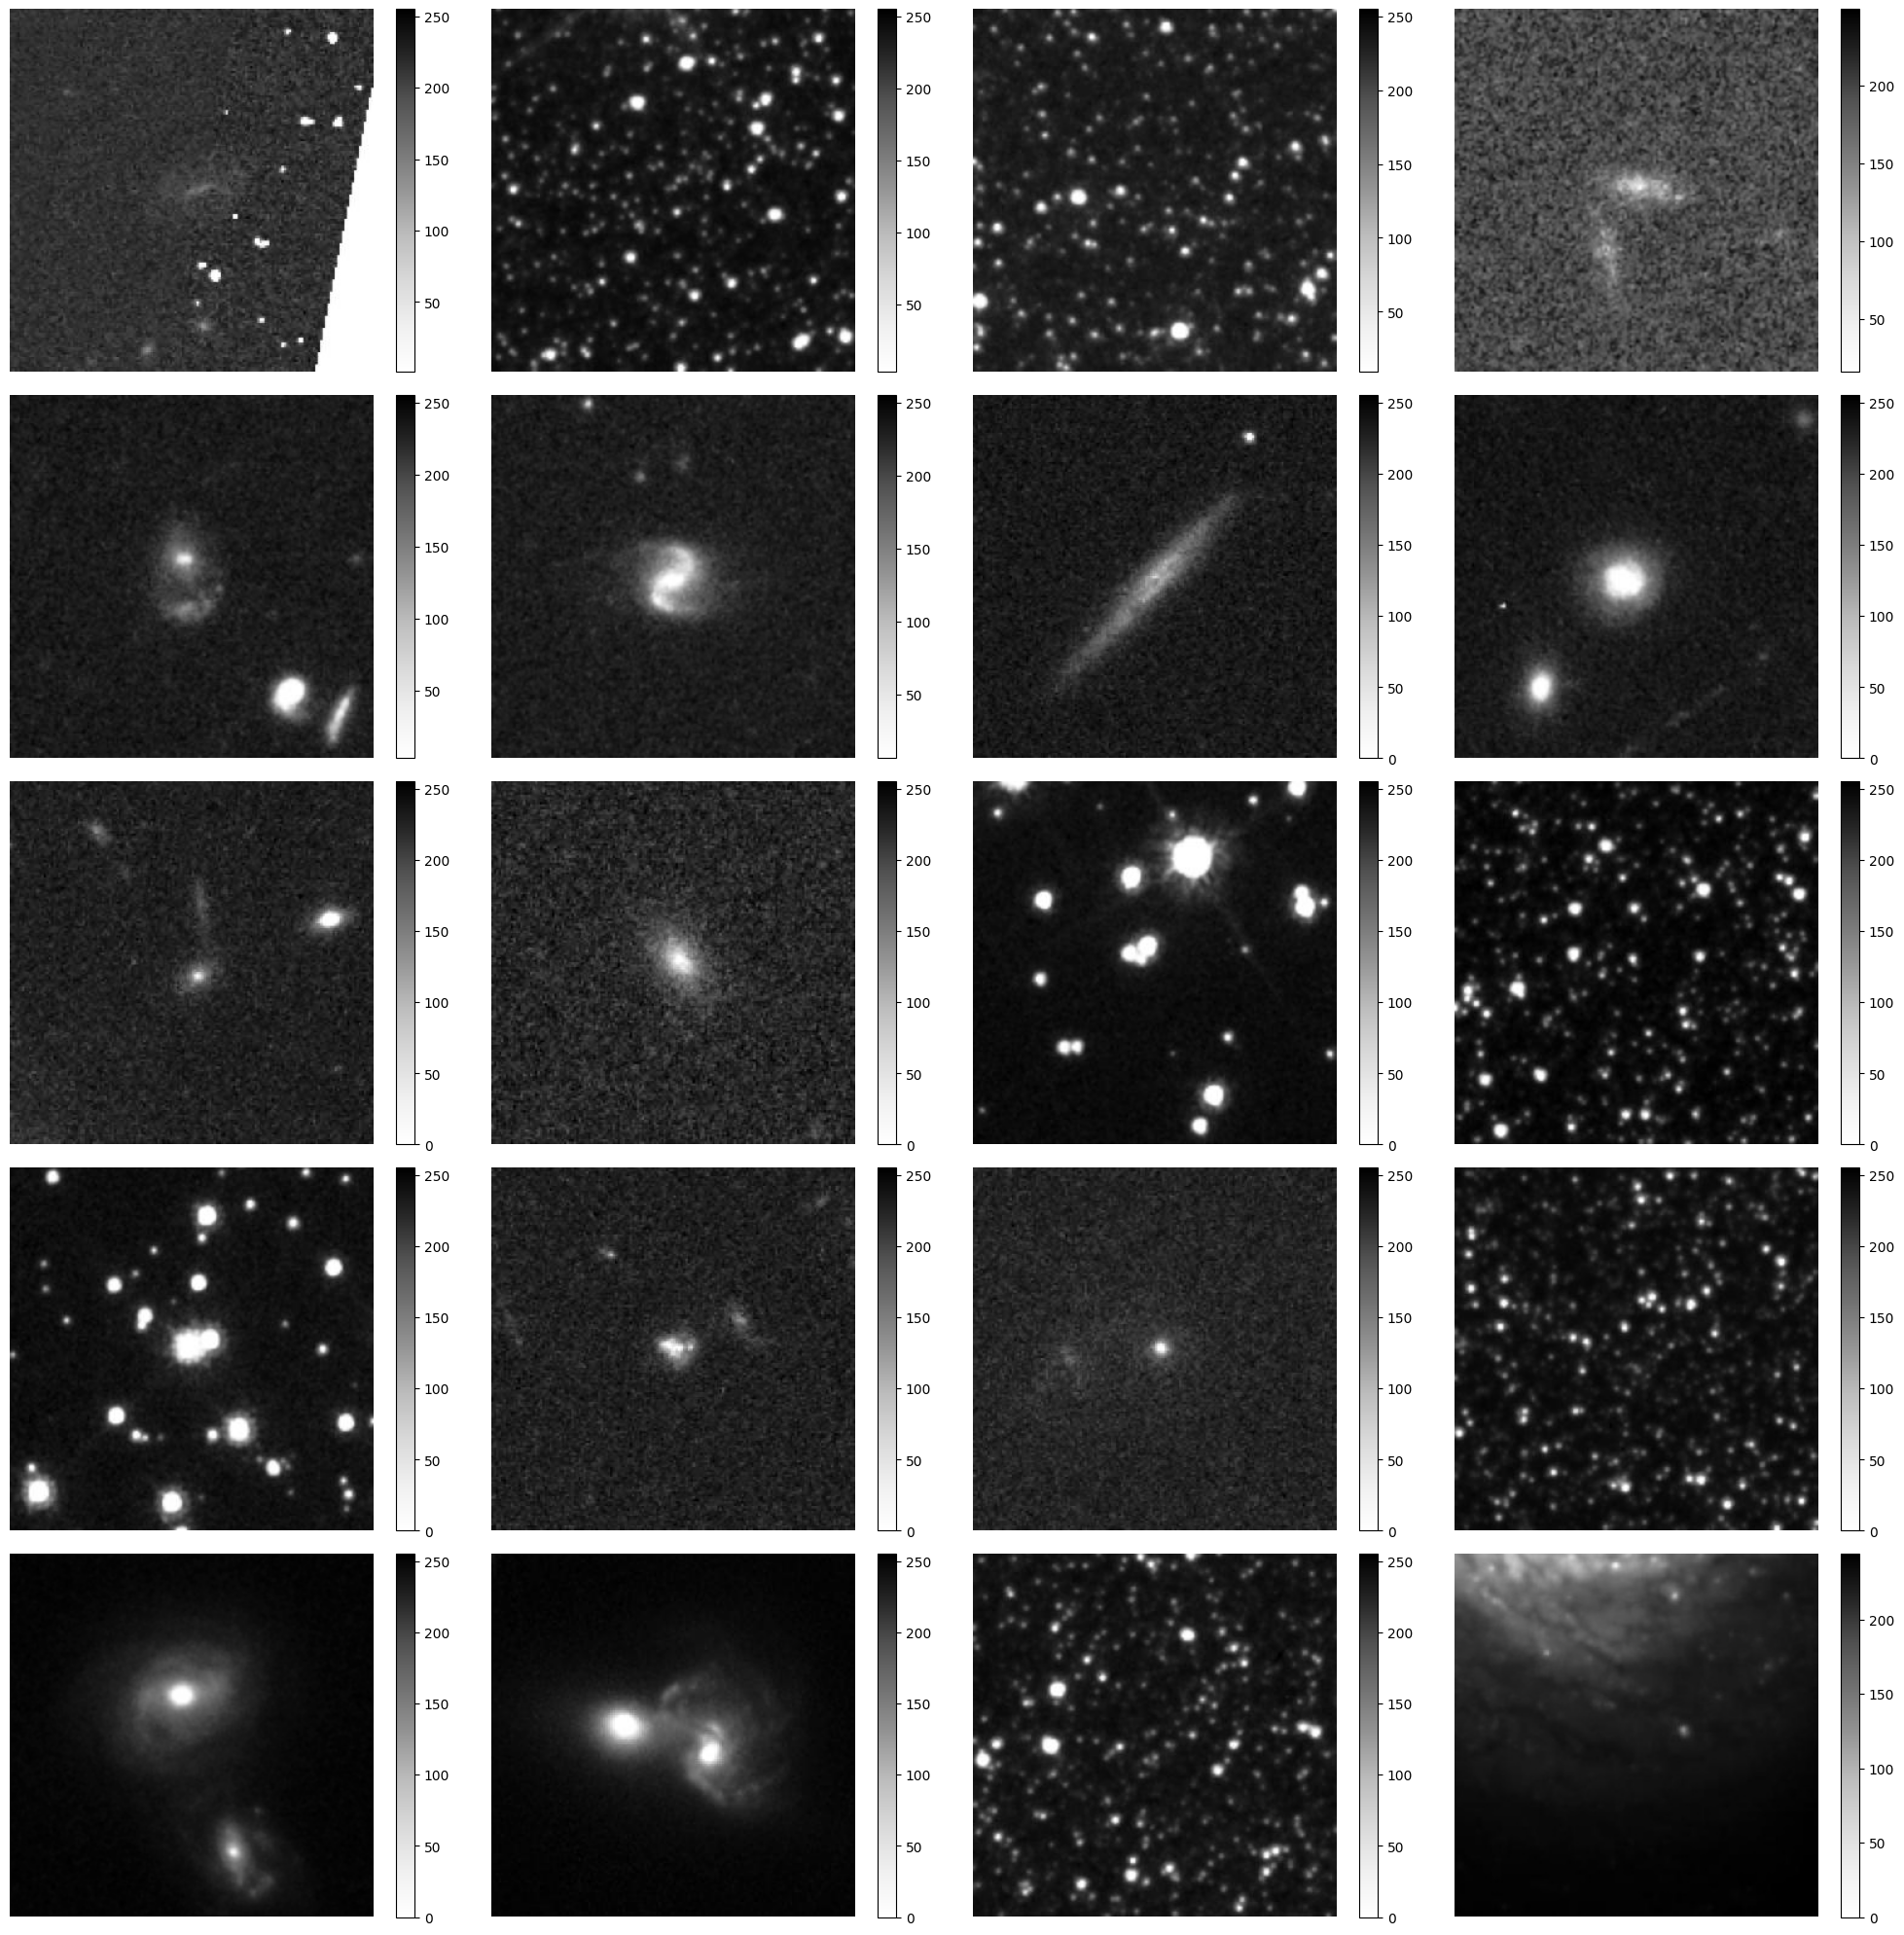

In [236]:
plt.figure(figsize= (20,20));
images_1 = []

for cnt, images_path in enumerate(non_random_images, 1):         # start= 1 the cnt-count enumerate images from non_random images 
    im = Image.open(images_path)
    images_1.append(im.copy())                                     # store the images

    plt.subplot(5, 4, cnt)
    plt.imshow(im, cmap= 'Greys')
    plt.axis('off');
    plt.colorbar()

plt.tight_layout()

### Randomly generated images

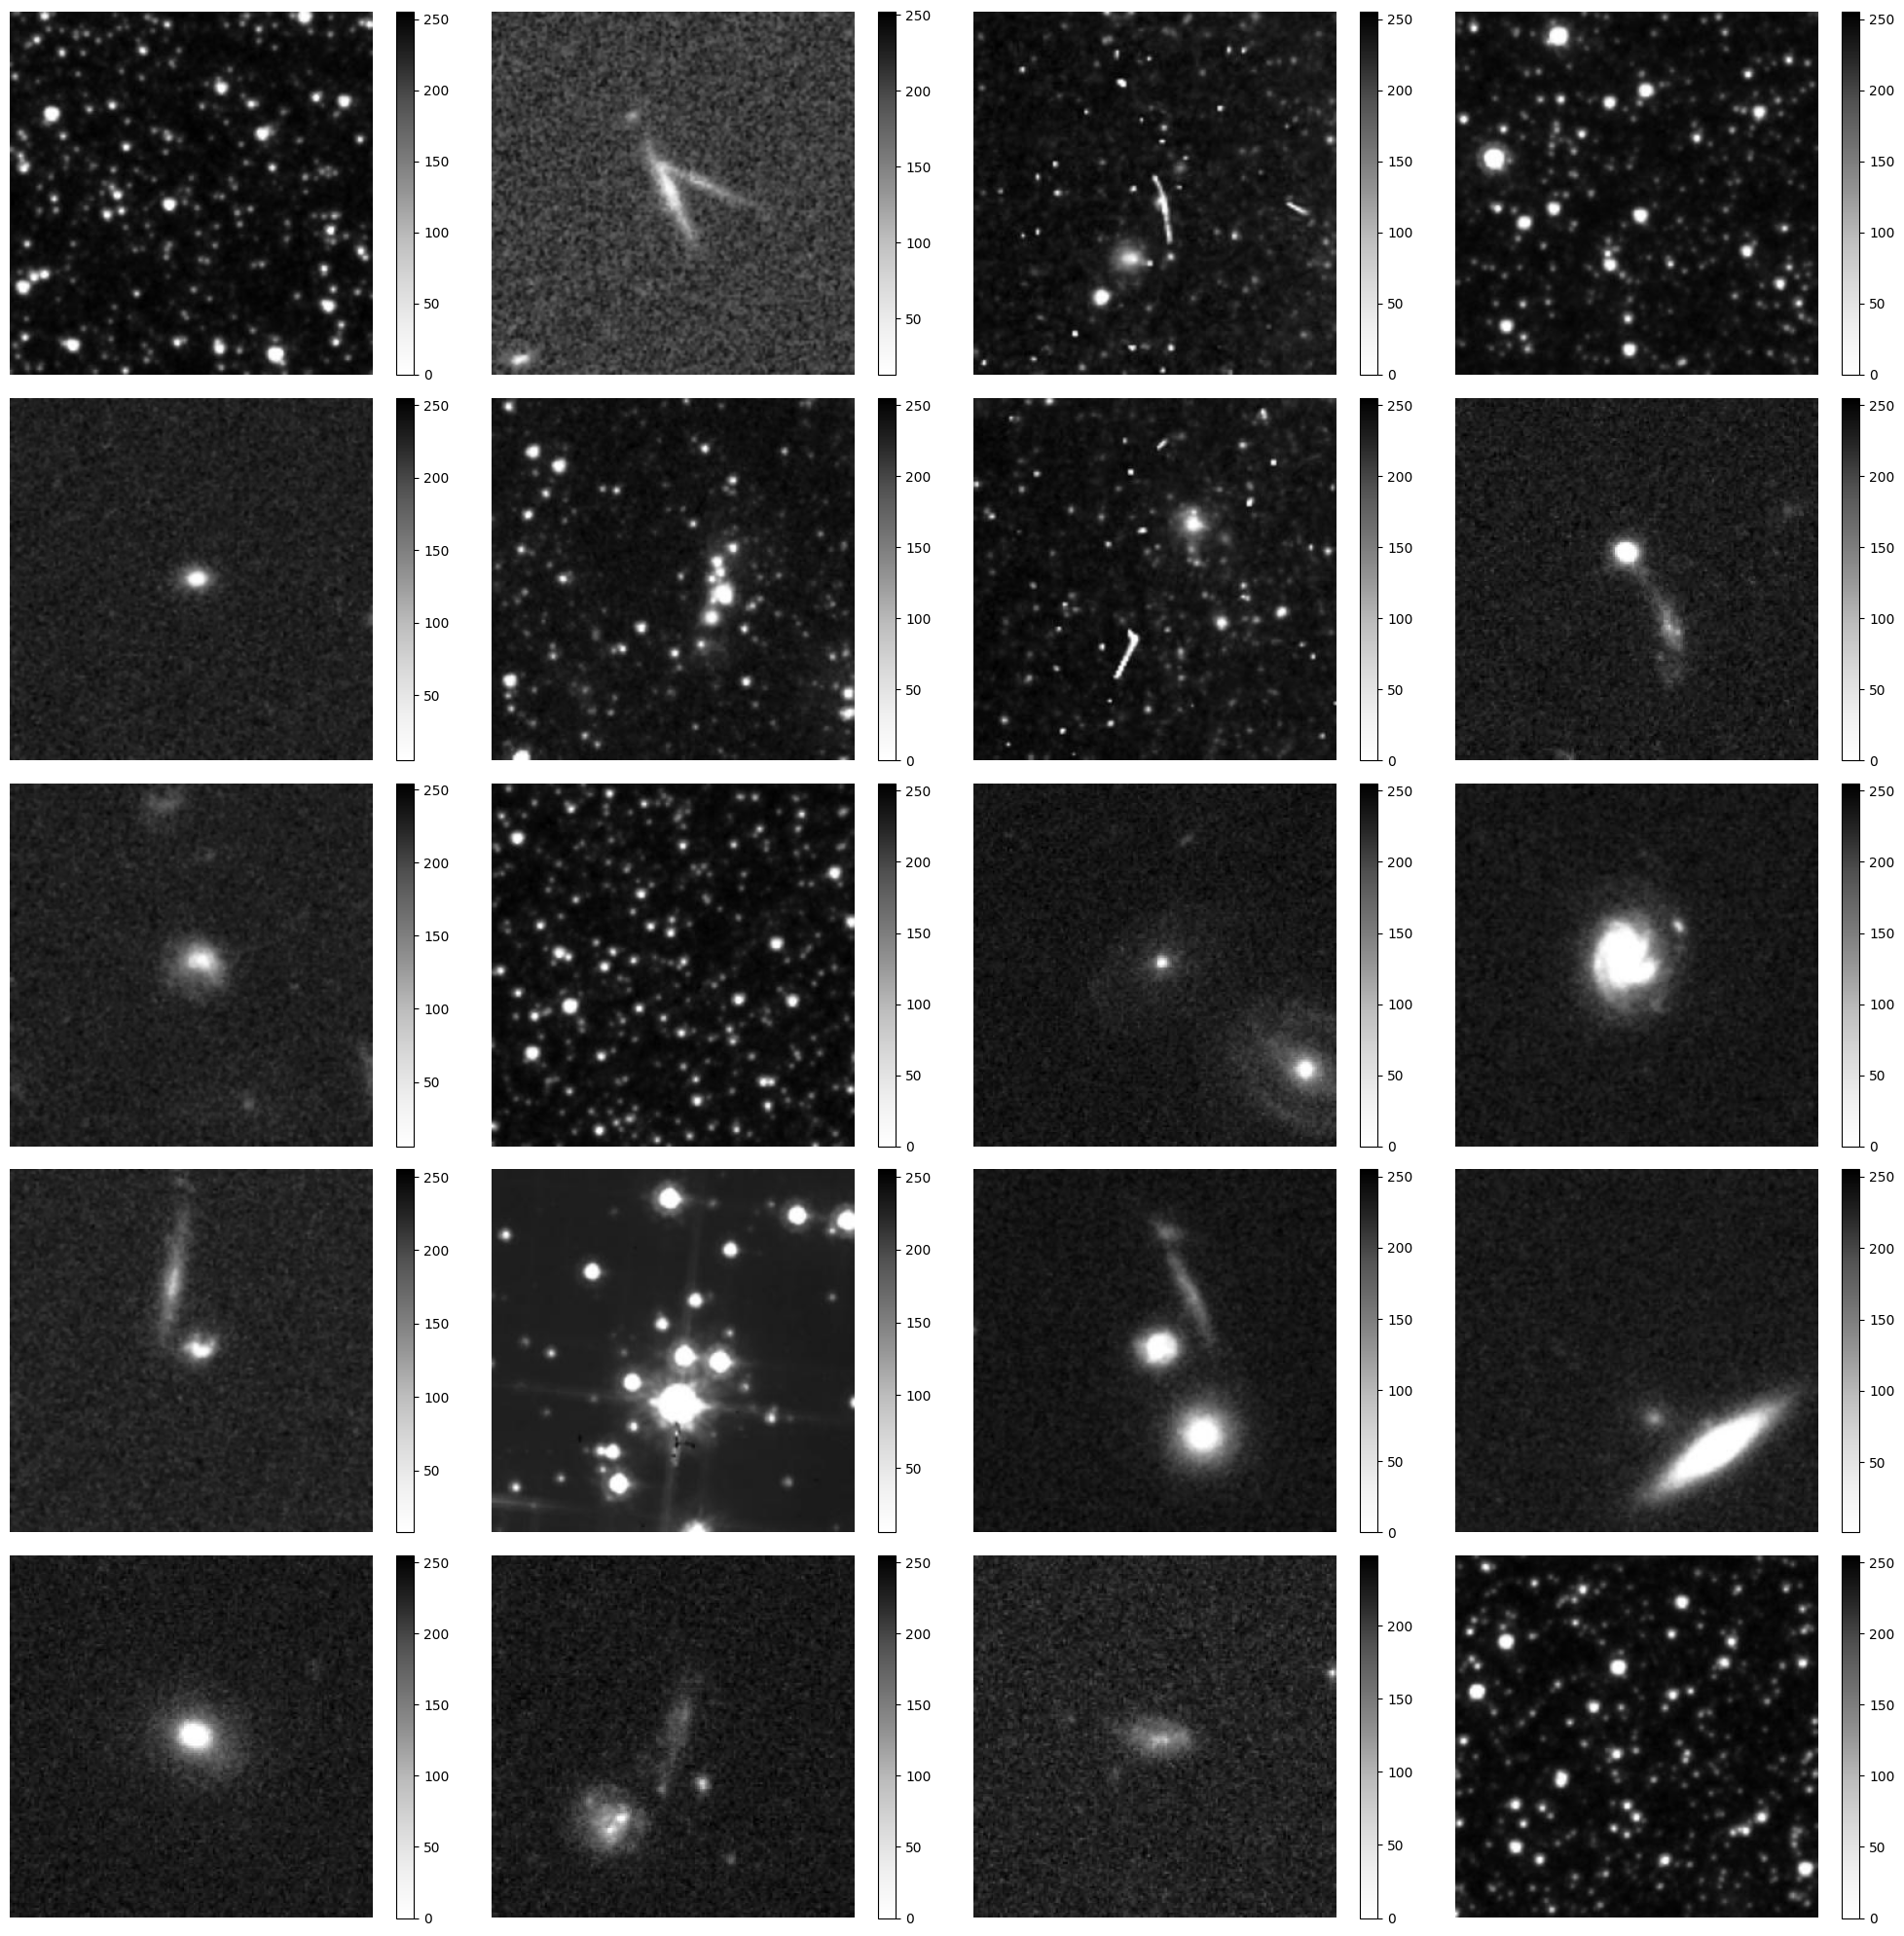

In [237]:
plt.figure(figsize= (20,20))
images_2 = [] 

for cnt, image in enumerate(random_images, 1):                       # start= 1 the cnt-count enumerate images from non_random images 
    im = Image.open(image)  
    images_2.append(im.copy())                                         # store the images
    
    # plot 20 randomly chosen images in a single layout
    plt.subplot(5, 4, cnt) 
    plt.imshow(im, cmap= 'Greys')
    plt.colorbar()
    plt.axis('off');

plt.tight_layout()


### We can Go on to compare the images

### Most anomalous sources  - most significant anomalies (the worst outliers)


In [238]:
# plot the top 20 high scoring anomalies/outliers
# Ive already found the negative scores earlier

In [239]:
# top 20 anomalies(highest negative scores)
top_anomalies = np.argsort(lof_score)[:20]                              # from numpy we can use argsort to sort the highest scores in order

# anomalies path from matadata
anomalies_paths = metadata.iloc[top_anomalies]['file_loc']


##

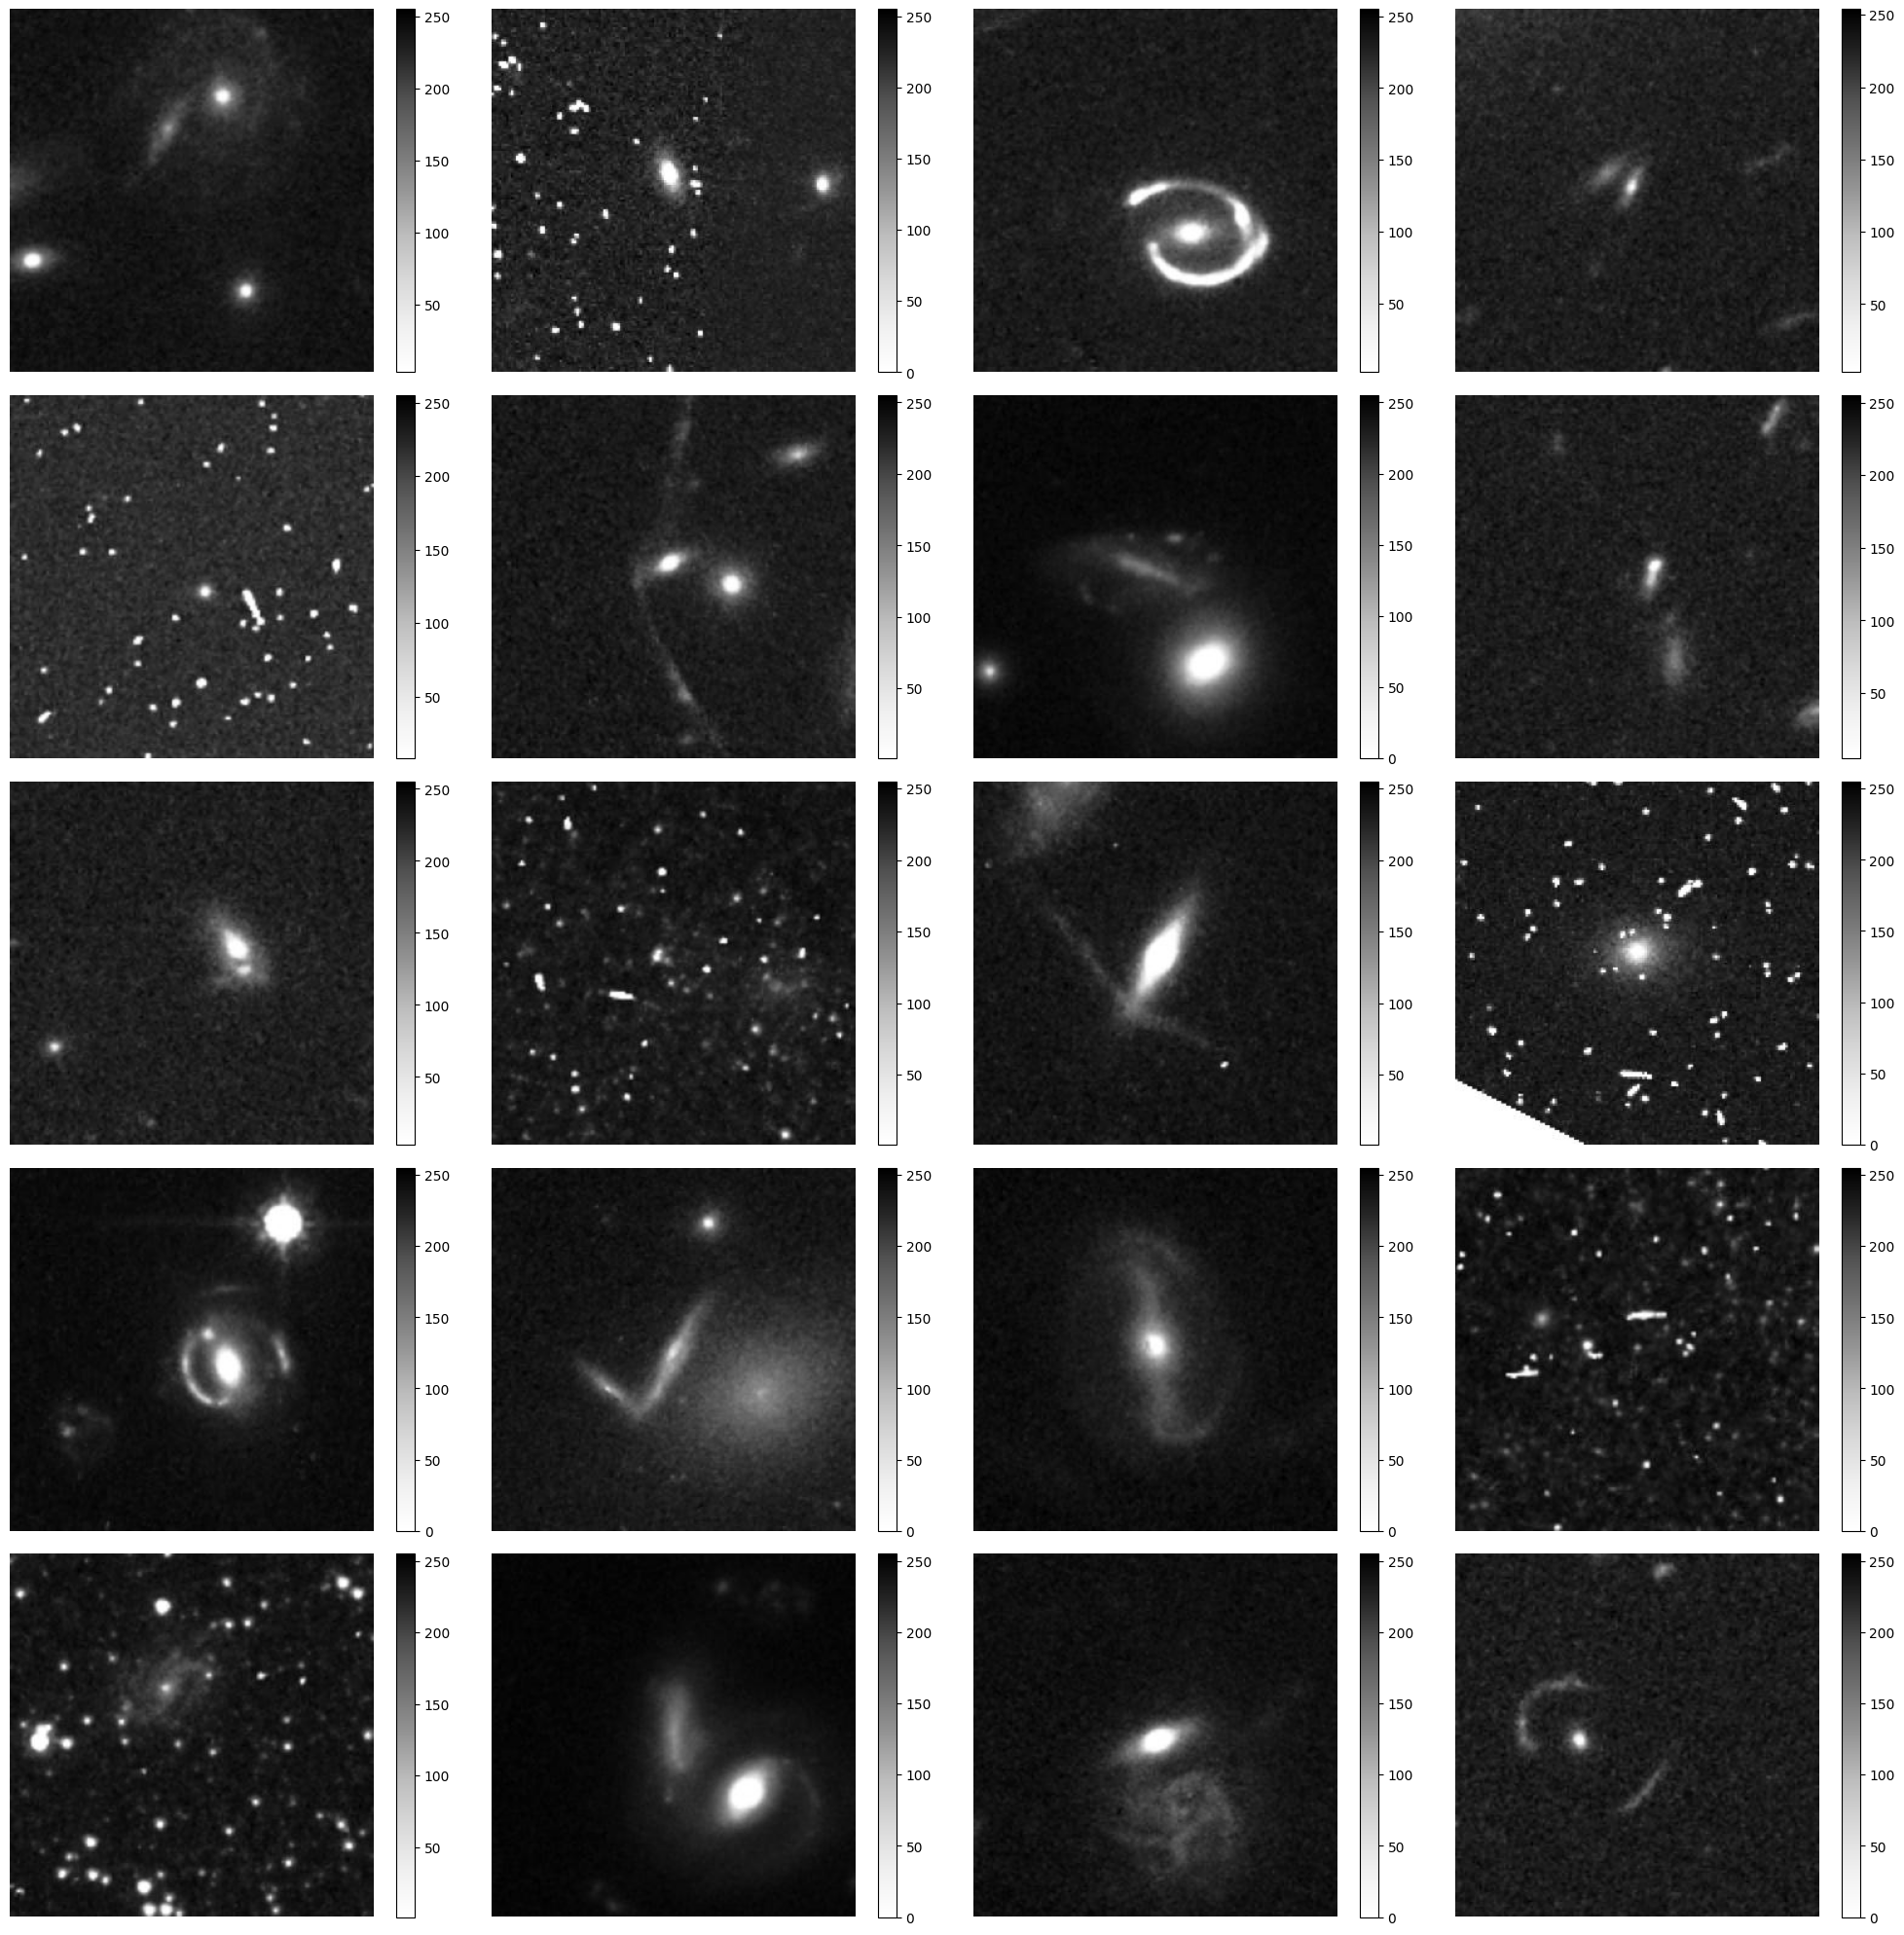

In [240]:
plt.figure(figsize= (20,20))
images_3 = [] 

for cnt, anomalies in enumerate(anomalies_paths, 1):                       # start= 1 the cnt-count enumerate images from non_random images 
    im = Image.open(anomalies)  
    images_3.append(im.copy())                                               # store the images
    
    # plot 20 randomly chosen images in a single layout
    plt.subplot(5, 4, cnt) 
    plt.imshow(im, cmap= 'Greys')
    plt.colorbar()
    plt.axis('off');

plt.tight_layout()

### galaxies with high LOF scores physically unusual/'boring galaxies'

### Shapes are weird and very bright as LOF increase

In [241]:
anomalies_paths

13836    /media/team_workspaces/astronomaly-project/ima...
2924     /media/team_workspaces/astronomaly-project/ima...
12030    /media/team_workspaces/astronomaly-project/ima...
17565    /media/team_workspaces/astronomaly-project/ima...
1677     /media/team_workspaces/astronomaly-project/ima...
1155     /media/team_workspaces/astronomaly-project/ima...
11997    /media/team_workspaces/astronomaly-project/ima...
14888    /media/team_workspaces/astronomaly-project/ima...
17556    /media/team_workspaces/astronomaly-project/ima...
14988    /media/team_workspaces/astronomaly-project/ima...
10958    /media/team_workspaces/astronomaly-project/ima...
2010     /media/team_workspaces/astronomaly-project/ima...
3460     /media/team_workspaces/astronomaly-project/ima...
14586    /media/team_workspaces/astronomaly-project/ima...
4158     /media/team_workspaces/astronomaly-project/ima...
7704     /media/team_workspaces/astronomaly-project/ima...
10472    /media/team_workspaces/astronomaly-project/ima.

###

In [242]:
## source RA and Dec
Ra_Dec = source_coords.iloc[top_anomalies]

Ra_Dec

RA                  Dec  \
SourceID                                                 
AHZ2001rhs            150.6204619            2.6257818   
4503132549            280.8188915          -32.3068091   
AHZ2001sn4            149.7237463            2.6515991   
4500683998            195.2378269           27.7885794   
AHZ2001aes            149.8903618            2.5082287   
4502550853            344.7125207          -34.7830028   
4000712929903  11.476284800000002            42.008575   
4229237259            112.1838786           69.1887429   
4000709474620         352.1386315           14.7481609   
26876457                      NaN                  NaN   
AHZ10000xt     214.22401659999997           52.4065568   
AHZ2000l0z            149.7658393            2.0546258   
AHZ20003mj            150.3819068            1.6414717   
GDS_17971      53.044959999999996           -27.749414   
4506361271            201.4233398          -47.5620034   
4181422040            197.8783857  -1.3418656999999998   
AHZ2001otb            150.3630268            1.6292875   
4233114577             13.3699131   -73.39834859999999   
AHZ2001h8y             150.050641            2.7773178   
4000895306159         150.0766791            2.6459884   

                                                        file_loc  
SourceID                                                          
AHZ2001rhs     /media/team_workspaces/astronomaly-project/ima...  
4503132549     /media/team_workspaces/astronomaly-project/ima...  
AHZ2001sn4     /media/team_workspaces/astronomaly-project/ima...  
4500683998     /media/team_workspaces/astronomaly-project/ima...  
AHZ2001aes     /media/team_workspaces/astronomaly-project/ima...  
4502550853     /media/team_workspaces/astronomaly-project/ima...  
4000712929903  /media/team_workspaces/astronomaly-project/ima...  
4229237259     /media/team_workspaces/astronomaly-project/ima...  
4000709474620  /media/team_workspaces/astronomaly-project/ima...  
26876457       /media/team_workspaces/astronomaly-project/ima...  
AHZ10000xt     /media/team_workspaces/astronomaly-project/ima...  
AHZ2000l0z     /media/team_workspaces/astronomaly-project/ima...  
AHZ20003mj     /media/team_workspaces/astronomaly-project/ima...  
GDS_17971      /media/team_workspaces/astronomaly-project/ima...  
4506361271     /media/team_workspaces/astronomaly-project/ima...  
4181422040     /media/team_workspaces/astronomaly-project/ima...  
AHZ2001otb     /media/team_workspaces/astronomaly-project/ima...  
4233114577     /media/team_workspaces/astronomaly-project/ima...  
AHZ2001h8y     /media/team_workspaces/astronomaly-project/ima...  
4000895306159  /media/team_workspaces/astronomaly-project/ima...

In [243]:
Ra_Dec = pd.DataFrame(Ra_Dec)

In [244]:
Ra_Dec.shape

(20, 3)

In [245]:
Ra_Dec

RA                  Dec  \
SourceID                                                 
AHZ2001rhs            150.6204619            2.6257818   
4503132549            280.8188915          -32.3068091   
AHZ2001sn4            149.7237463            2.6515991   
4500683998            195.2378269           27.7885794   
AHZ2001aes            149.8903618            2.5082287   
4502550853            344.7125207          -34.7830028   
4000712929903  11.476284800000002            42.008575   
4229237259            112.1838786           69.1887429   
4000709474620         352.1386315           14.7481609   
26876457                      NaN                  NaN   
AHZ10000xt     214.22401659999997           52.4065568   
AHZ2000l0z            149.7658393            2.0546258   
AHZ20003mj            150.3819068            1.6414717   
GDS_17971      53.044959999999996           -27.749414   
4506361271            201.4233398          -47.5620034   
4181422040            197.8783857  -1.3418656999999998   
AHZ2001otb            150.3630268            1.6292875   
4233114577             13.3699131   -73.39834859999999   
AHZ2001h8y             150.050641            2.7773178   
4000895306159         150.0766791            2.6459884   

                                                        file_loc  
SourceID                                                          
AHZ2001rhs     /media/team_workspaces/astronomaly-project/ima...  
4503132549     /media/team_workspaces/astronomaly-project/ima...  
AHZ2001sn4     /media/team_workspaces/astronomaly-project/ima...  
4500683998     /media/team_workspaces/astronomaly-project/ima...  
AHZ2001aes     /media/team_workspaces/astronomaly-project/ima...  
4502550853     /media/team_workspaces/astronomaly-project/ima...  
4000712929903  /media/team_workspaces/astronomaly-project/ima...  
4229237259     /media/team_workspaces/astronomaly-project/ima...  
4000709474620  /media/team_workspaces/astronomaly-project/ima...  
26876457       /media/team_workspaces/astronomaly-project/ima...  
AHZ10000xt     /media/team_workspaces/astronomaly-project/ima...  
AHZ2000l0z     /media/team_workspaces/astronomaly-project/ima...  
AHZ20003mj     /media/team_workspaces/astronomaly-project/ima...  
GDS_17971      /media/team_workspaces/astronomaly-project/ima...  
4506361271     /media/team_workspaces/astronomaly-project/ima...  
4181422040     /media/team_workspaces/astronomaly-project/ima...  
AHZ2001otb     /media/team_workspaces/astronomaly-project/ima...  
4233114577     /media/team_workspaces/astronomaly-project/ima...  
AHZ2001h8y     /media/team_workspaces/astronomaly-project/ima...  
4000895306159  /media/team_workspaces/astronomaly-project/ima...

In [246]:
Ra_Dec.iloc[0]

RA                                                150.6204619
Dec                                                 2.6257818
file_loc    /media/team_workspaces/astronomaly-project/ima...
Name: AHZ2001rhs, dtype: object

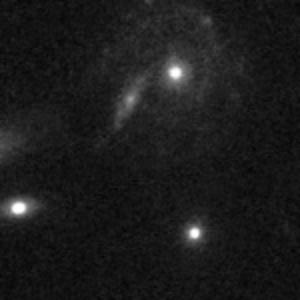

In [247]:
images_3[0]

#Ra_Dec[1]

In [248]:
import matplotlib.image as mpimg

# Assume top_anomalies[0] contains the index of the strongest anomaly
strongest_anomaly_index = top_anomalies[0]


galaxy = source_coords.iloc[strongest_anomaly_index]
Ra = galaxy['RA'] 
Dec = galaxy['Dec']   

galaxy

RA                                                150.6204619
Dec                                                 2.6257818
file_loc    /media/team_workspaces/astronomaly-project/ima...
Name: AHZ2001rhs, dtype: object

### Galaxy Properties:
### id: 4001388995406
### Location: /media/team_workspaces/astronomaly-project/images/18k-sample/4001388995406.jpeg
### Ra: 150.6204619
### Dec: 2.6257818